In [ ]:
import numpy as np 
import matplotlib.pylab as plt 
from ml_collections import ConfigDict
import scipy.stats 
from scipy.integrate import simpson
from scipy.interpolate import interp1d

from getdist import plots, MCSamples
import getdist

# our scripts
from src.cosmo import calculate_pk_fixed_redshift
from config import get_config

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
contours = [0.68,0.95]
linewidth = 2 

In [ ]:
configs = get_config()

In [ ]:
npower = 15 
omega_cdm_min = 0.10 
omega_cdm_max = 0.25

wavenumbers = np.geomspace(configs.grid.kmin, configs.grid.kmax, configs.grid.nk)
omega_cdm_grid = np.linspace(omega_cdm_min, omega_cdm_max, npower)
cosmo = {'omega_cdm': 0.10, 'omega_b': 0.022, 'S_8': 0.75, 'n_s': 1.0, 'h': 0.75}

In [ ]:
record_pk = list()

for i in range(npower):
    cosmo['omega_cdm'] = omega_cdm_grid[i]
    pk = calculate_pk_fixed_redshift(configs, cosmo, 0)
    record_pk.append(pk)

In [ ]:
record_pk = np.asarray(record_pk)

## Total Power Spectrum

In [ ]:
nbias = len(configs.bias.fiducial)
bias_prod = np.outer(configs.bias.fiducial, configs.bias.fiducial)
bias_prod = bias_prod[np.triu_indices(nbias)].reshape(1, -1)
total_pk = np.dot(bias_prod, record_pk).reshape(-1)

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(npower):
    plt.loglog(wavenumbers, record_pk[i], lw = 2)
plt.loglog(wavenumbers, total_pk, lw = 3)
plt.xlim(configs.grid.kmin, configs.grid.kmax)
plt.ylabel(r'$P_{\delta}(k, z=0)\;[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

## Noisy $P_{\delta}$

In [ ]:
sigma = np.ones(configs.grid.nk) * total_pk * 0.20
noise = np.random.randn(configs.grid.nk) * sigma
data = total_pk + noise

In [ ]:
plt.figure(figsize = (12, 8))
plt.loglog(wavenumbers, total_pk, lw = 3, label = 'Total Power Spectrum (Fiducial)')
plt.errorbar(wavenumbers, data, yerr=sigma, fmt = 'ro', label = 'Noisy Power Spectrum')
plt.xlim(configs.grid.kmin, configs.grid.kmax)
plt.ylabel(r'$P_{\delta}(k, z=0)\;[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':20})
plt.show()

## Sampling

In [ ]:
def calculate_theory(bias: dict, power_spectra: np.ndarray) -> np.ndarray:
    """
    bias: len(bias) = 5 
    power_spectra: shape = 15 x 100
    """
    nbias = len(bias)
    bias = list(bias.values())
    bias_prod = np.outer(bias, bias)
    bias_prod = bias_prod[np.triu_indices(nbias)].reshape(1, -1)
    total_pk = np.dot(bias_prod, power_spectra).reshape(-1)
    return total_pk

In [ ]:
def calculate_log_likelihood(data: np.ndarray, theory: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    diff = (data - theory )/sigma
    return -0.5 * np.sum(diff * diff)    

In [ ]:
def generate_bias_prior(config: ConfigDict) -> dict:
    """Generates the entity of each parameter by using scipy.stats function.
    Args:
        dictionary (dict): A dictionary with the specifications of the prior.
    Returns:
        dict: the prior distribution of all parameters.
    """
    dictionary = dict()
    for i, key in enumerate(config.bias.names):
        specs = (config.bias.loc[i], config.bias.scale[i])
        dictionary[key] = getattr(scipy.stats, config.bias.distribution)(*specs)
    return dictionary

In [ ]:
# test_bias = np.array([0.9, 1.4, 1.9, 2.4, 2.8])
test_bias = dict(zip(configs.bias.names, configs.bias.fiducial))
test = calculate_theory(test_bias, record_pk)

In [ ]:
calculate_log_likelihood(data, test, sigma)

## Test on a Grid

In [ ]:
def distribution(bias_param: dict, bias_prior, ref = 'b0'):
    theory = calculate_theory(bias_param, record_pk)
    loglike = calculate_log_likelihood(data, theory, sigma)
    logprior = bias_prior[ref].logpdf(bias_param[ref])
    return np.exp(loglike + logprior)

In [ ]:
def pdf_cdf(configs, bias_grid: np.ndarray, bias_params, bias_prior, ref = 'b0'):
    ngrid = len(bias_grid)
    bias_params = bias_params.reshape(1, -1)
    bias_repeat = np.repeat(bias_params, ngrid, axis = 0)
    idx = configs.bias.names.index(ref)
    bias_repeat[:, idx] = bias_grid
    
    pdfs = list()
    for b in bias_repeat:
        bparam = dict(zip(configs.bias.names, b))
        pdfs.append(distribution(bparam, bias_prior, ref))
    
    pdf = pdfs/simpson(pdfs, bias_grid)
    cdf = np.cumsum(pdf)
    cdf /= max(cdf)
    return pdf, cdf

In [ ]:
def sample_bias(nsample, configs, bias_grid, bias_params, bias_prior, ref = 'b0'):
    u = np.random.uniform(0, 1, nsample)
    pdf, cdf = pdf_cdf(configs, bias_grid, bias_params, bias_prior, ref)
    func_interp = interp1d(cdf, bias_grid)
    samples = func_interp(u)
    return samples

In [ ]:
bgrid = np.linspace(0, 5, 1000)
bfid = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
priors = generate_bias_prior(configs)

In [ ]:
record_bias = dict()
for bname in configs.bias.names:
    pdf, cdf = pdf_cdf(configs, bgrid, bfid, priors, bname)
    samples = sample_bias(10000, configs, bgrid, bfid, priors, bname)
    record_bias[bname] = (pdf, cdf, samples)

In [ ]:
for bname in configs.bias.names:
    print(f'{bname}: {bgrid[np.argmax(record_bias[bname][0])]:.4f}')

In [ ]:
maxpdf = list()
plt.figure(figsize = (12, 8))
for bname in configs.bias.names:
    pdf, cdf, samples = record_bias[bname]
    plt.plot(bgrid, pdf)
    plt.hist(samples, density=True, bins=20, alpha = 0.5)
    maxpdf.append(np.max(pdf))
plt.ylabel(r'$p(b_{\alpha})$', fontsize = fontSize)
plt.xlabel(r'$b_{\alpha}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 1.2 * np.max(maxpdf))
plt.xlim(0, 5)
plt.show()

# Gibbs Sampling

In [ ]:
bgrid = np.linspace(0, 5, 100)
bfid = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
priors = generate_bias_prior(configs)

In [ ]:
ngibbs = 10000
trace = np.zeros((ngibbs, 5))

for g in range(ngibbs):
    for i, bname in enumerate(configs.bias.names):
    
        param = sample_bias(1, configs, bgrid, bfid, priors, bname)
        bfid[i] = param        
    trace[g] = bfid

## Triangle Plot

In [ ]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels =  [r"$b_{0}$", r"$b_{1}$", r"$b_{2}$", r"$b_{s}$", r"$b_{\nabla}$"]
samples = MCSamples(samples=trace,names = names, labels = labels, settings = settings)

In [ ]:
G = plots.getSubplotPlotter(subplot_size=2)
samples.updateSettings({'contours': contours})
G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':'blue'}, contour_colors=['blue'])
G.settings.num_plot_contours = 2
G.settings.solid_contour_palefactor = 0.5
G.settings.alpha_filled_add = 0.2

for i in range(0,5):
    for j in range(0, i+1):
        if i != j:
            ax = G.subplots[i,j]
            
            a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
            density = G.sample_analyser.get_density_grid(samples, a, b)
            density.contours = density.getContourLevels(contours)
            contour_levels = density.contours
            
            ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = 'blue', linewidths = linewidth) 
            ax.tick_params(axis = 'x', labelsize = fontSize, rotation=45, pad=5)
            ax.tick_params(axis = 'y', labelsize = fontSize, pad=5)
            ax.yaxis.label.set_size(fontSize)
            ax.xaxis.label.set_size(fontSize)
            ax.xaxis.labelpad = 20
            ax.yaxis.labelpad = 20
        else:
            ax = G.subplots[i,j]   
            
            dense = samples.get1DDensity('x'+str(i))
            dense.normalize(by='max')
            ax.plot(dense.x, dense.P, lw = linewidth, c = 'blue')
            
            ax.tick_params(axis = 'x', labelsize = fontSize, rotation=45, pad=5)
            ax.tick_params(axis = 'y', labelsize = fontSize, pad=5)
            ax.yaxis.label.set_size(fontSize)
            ax.xaxis.label.set_size(fontSize)
            ax.xaxis.labelpad = 20
            ax.yaxis.labelpad = 20
plt.show()

## Experiment: Kernel Interpolation

In [1]:
import torch
import matplotlib.pylab as plt 

# our script and functions 
from utils.interpolation import KernelInterpolation 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
fontSize = 20

In [2]:
xmin = 0.0 
xmax = 2.0 * torch.pi 
ndata = 25
Ndata = 500
x = torch.linspace(xmin, xmax, ndata)
xnew = torch.linspace(xmin, xmax, Ndata)
y = torch.sin(x)

In [3]:
interp = KernelInterpolation(x, y, hyperparam=1.0)
ynew = interp.predict(xnew)

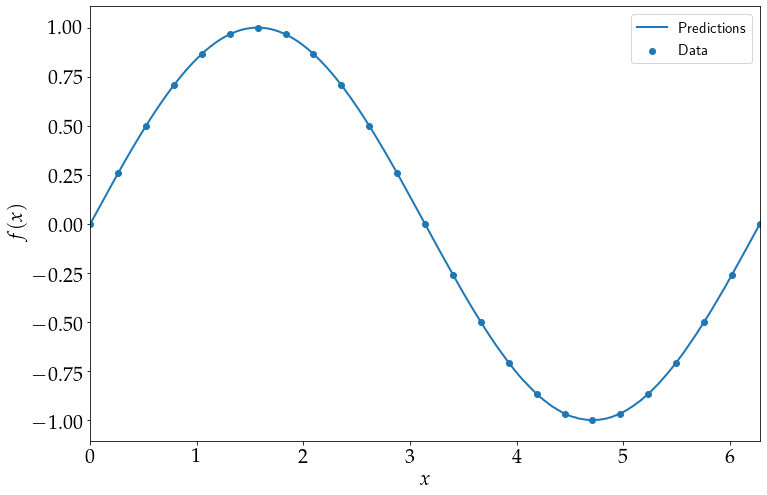

In [4]:
plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Data')
plt.plot(xnew, ynew, lw = 2, label = 'Predictions')
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(xmin, xmax)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

## Test Training Set 

In [10]:
import torch
import numpy as np
import matplotlib.pylab as plt 
import pandas as pd 
from typing import Tuple
from ml_collections import ConfigDict

from config import get_config
from src.cosmology.cosmo import calculate_pk_fixed_redshift
from trainingpoints import scale_lhs
import utils.helpers as hp
from utils.interpolation import KernelInterpolation

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
fontSize = 20

In [11]:
cosmo = {'omega_cdm':0.12, 'omega_b':0.02, 'S_8':0.8, 'n_s':1.0, 'h':0.7}
# 1454.6482
redshift = 0.0

In [13]:
config = get_config()
fname = 'lhs_1000'

In [16]:
calculate_pk_fixed_redshift(config, cosmo, redshift)

array([1.50393170e+03, 1.98403137e+03, 2.61666643e+03, 3.44939819e+03,
       4.54355538e+03, 5.97708787e+03, 7.84697766e+03, 1.02701779e+04,
       1.33812579e+04, 1.73239547e+04, 2.22346025e+04, 2.82087486e+04,
       3.52464594e+04, 4.31751760e+04, 5.15459554e+04, 5.95305373e+04,
       6.58084767e+04, 6.85869829e+04, 6.60305144e+04, 5.75759378e+04,
       4.58887660e+04, 3.62906684e+04, 3.01367292e+04, 2.13972188e+04,
       1.48933272e+04, 1.03986591e+04, 7.34264179e+03, 4.97933491e+03,
       3.44554230e+03, 2.51009207e+03, 1.90042442e+03, 1.47907689e+03,
       1.15165774e+03, 8.71729280e+02, 6.29007182e+02, 4.30444808e+02,
       2.80930680e+02, 1.76372932e+02, 1.07360767e+02, 6.36948267e+01])

In [3]:
def pk_training_set(fname: str, config: ConfigDict, redshift: float = 0.0) -> Tuple[list, np.ndarray]:
    """Generates the training set for building the emulator.

    Args:
        fname (str): name of the LHS file.
        config (ConfigDict): the main configuration file with all settings.
        redshift (float, optional): the redshift at which the power spectrum is calculated. Defaults to 0.0.

    Returns:
        Tuple[list, np.ndarray]: the cosmologies and the power spectra
    """
    logger.info('Generating training points.')
    cosmologies = scale_lhs(config, fname, save=True)
    pk_record = list()
    for i, cosmo in enumerate(cosmologies[0:10]):
        print(i, cosmo)
        pk_calc = calculate_pk_fixed_redshift(config, cosmo, redshift)
        pk_record.append(pk_calc)

    pk_record = np.asarray(pk_record)
    if config.boolean.linearpk:
        filename = 'pk_lin_' + fname
    else:
        filename = 'pk_non_' + fname
    hp.save_pkl(pk_record, "data", filename)
    return cosmologies, pk_record


In [4]:
cosmo, pk = pk_training_set(fname, config, 0.0)

0 {'omega_cdm': 0.134518, 'omega_b': 0.023949, 'S_8': 0.650139, 'n_s': 1.021041, 'h': 0.709579}
1 {'omega_cdm': 0.132537, 'omega_b': 0.021998, 'S_8': 1.115088, 'n_s': 0.913569, 'h': 0.697035}
2 {'omega_cdm': 0.10486, 'omega_b': 0.024739, 'S_8': 0.416128, 'n_s': 1.040089, 'h': 0.673051}
3 {'omega_cdm': 0.115297, 'omega_b': 0.025072, 'S_8': 0.318863, 'n_s': 0.910296, 'h': 0.78674}
4 {'omega_cdm': 0.204829, 'omega_b': 0.022295, 'S_8': 0.299814, 'n_s': 0.929285, 'h': 0.758575}
5 {'omega_cdm': 0.151178, 'omega_b': 0.023621, 'S_8': 0.51047, 'n_s': 0.997754, 'h': 0.73813}
6 {'omega_cdm': 0.215621, 'omega_b': 0.020408, 'S_8': 0.364479, 'n_s': 0.888963, 'h': 0.744773}
7 {'omega_cdm': 0.226004, 'omega_b': 0.02256, 'S_8': 0.740508, 'n_s': 0.956783, 'h': 0.678162}
8 {'omega_cdm': 0.217632, 'omega_b': 0.024607, 'S_8': 0.61376, 'n_s': 1.058074, 'h': 0.720435}
9 {'omega_cdm': 0.083149, 'omega_b': 0.020733, 'S_8': 1.034365, 'n_s': 1.026976, 'h': 0.749305}


In [15]:
x = np.geomspace(config.grid.kmin, config.grid.kmax, config.grid.nk)
x = torch.from_numpy(x)
x = torch.log(x)

xnew = np.geomspace(config.grid.kmin, config.grid.kmax, 1000)
xnew = torch.from_numpy(xnew)
xnew = torch.log(xnew)

y = torch.log(pk[0])

In [16]:
interp = KernelInterpolation(x, y, hyperparam=1.0)
ynew = interp.predict(xnew)

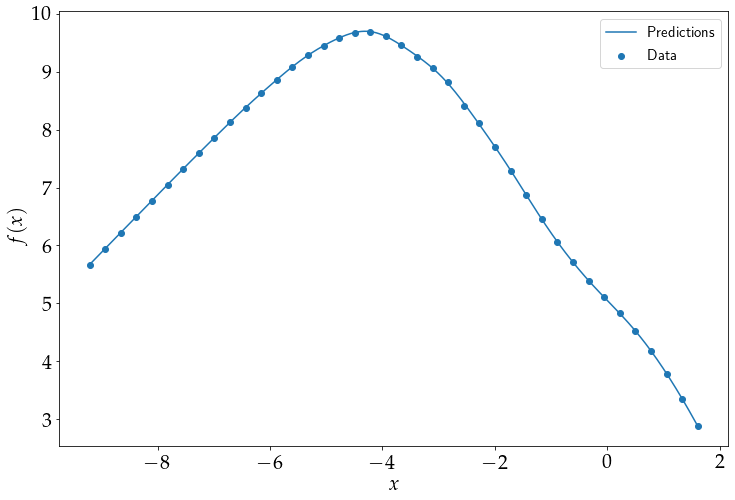

In [17]:
plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Data')
plt.plot(xnew, ynew, label = 'Predictions')
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.xlim(xmin, xmax)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Train GPs 

In [11]:
from src.emulator.training import train_gps
from config import get_config
import torch
import matplotlib.pylab as plt 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
fontSize = 20

In [2]:
cfg = get_config()

In [3]:
gps = train_gps(cfg)
gp = gps[0] # looking into first GP only

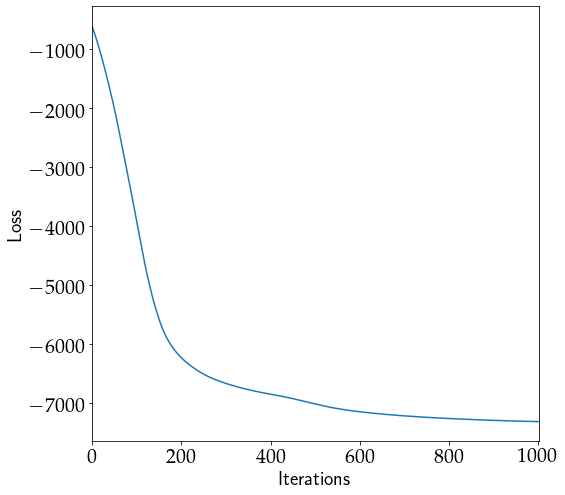

In [14]:
plt.figure(figsize = (8,8))
plt.plot(range(cfg.emu.niter + 1), gp.d_opt['loss'])
plt.xlim(0, cfg.emu.niter + 1)
plt.xlabel("Iterations", fontsize=fontSize)
plt.ylabel("Loss", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.show()

### Test Prediction

In [6]:
testpoint = torch.tensor([0.12, 0.02, 0.8, 1.0, 0.7])
gp.prediction(testpoint) # 1.50393170e+03

tensor([[1504.1843]], dtype=torch.float64)

In [7]:
gp.derivatives(testpoint)

tensor([-43119.9570,  -2997.8433,   3733.7258, -10556.2461,   1257.1094])